In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)
    
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

sys.version_info(major=3, minor=10, micro=14, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 1.26.4
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cu124
cuda:0


# 准备数据

这里使用subword分词，我们使用已经清洗好的数据集，可以从[此处](https://www.kaggleusercontent.com/kf/98352223/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..nKt8lrIW5ej5QJQVpOWuqQ.oLIgiLMONU5Gpj_maVudRJa55NSOCILxk4JNZhvuXmeDBR-oG0uQm7bDHBfSwZRGvOBHQTsRV308iNP80btfwMinQ7yvJNt-GwdQF4XR4DIsg-2CbEPYiMsi_NdbL0FmE9LYStKdxCWbrCZCCMrTmo5LxR1txwibXaSpeP5Inobhbez5zetZIRH210CBuX2JbpRc_DULQpazKbtFPitwyfktVmdG_syvVAU6Sk9b0r0_erYAgb_jkKXX1Mxo1KzWSKLcAvbmMIPcsUkx9PmeJDs_wopfsQsZ1h5jaQX4_l0CTZrEenP6lIPDxpTwXANqqdHspmZeeEIAThqCHC6sb5DxTvG89BwzY9rc53Aa0uX4V806wJVybnRXoaV65K4GqpjnxbBK0WC8G-2lNtrqFujE89KDXZjFPgyfOEj1QIu13oFNSjgs6o4VV1PdZOrhiNdSmjb44c22l_unOaFojzJgzcPxq9AG2lcmrOpdZ2qu1jjdwey-58TA2ZHNCo3XnjEe2n3ignpnbsdLFpo22O8QakSUHv91wuYDYdNi3AiSmltL_k2ChuKfJ0G8kATpLe4k8wA26sO4GMXg4HImOr3b4aDVEIWXdApHP0ecFKs6ELTo8O7X-TK8Jvbua7e6qpDfDc-r_cD73fVSgSek5yNmKQMBzuVcjkprXmcxICQ.kV1b4N1s64NERKnt4zwQgQ/imdb_processed.csv)下载，分词使用 [subword-nmt](https://github.com/rsennrich/subword-nmt)

In [11]:
cleaned_df = pd.read_csv("/mnt/workspace/chapter7/imdb_processed.csv")
print(cleaned_df.shape) # (50000, 2), 50000条评论, 2列

# 随机打乱数据，取训练集和测试集
np.random.seed(seed) #随机
cleaned_df = cleaned_df.sample(frac=1).reset_index(drop=True)#打乱，frac=1表示全部打乱（frac是比例，reset_index(drop=True)是重新索引
with open("/mnt/workspace/chapter7/imdb_train.txt", "w", encoding="utf8") as file:# 保存训练集
    for line in cleaned_df.processed.values[:25000]:#只保存了processed列，即评论文本，没有保存label列
        file.write(line.lower() + "\n") #变为小写，token数量少一些

with open("/mnt/workspace/chapter7/imdb_test.txt", "w", encoding="utf8") as file:# 保存测试集
    for line in cleaned_df.processed.values[25000:]:
        file.write(line.lower() + "\n")

(50000, 2)


In [3]:
# !pip install subword-nmt  

Looking in indexes: https://mirrors.cloud.aliyuncs.com/pypi/simple

[notice] A new release of pip is available: 23.3.2 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [13]:
# 学习bpe分词(很慢,学一次就好)
# -i 选择学习的文件
# -o 核心输出文件,分词需要用到imdb_bpe_code
# --write-vocabulary 字典输出文件
# -s 词表大小
!subword-nmt learn-joint-bpe-and-vocab -i /mnt/workspace/chapter7/imdb_train.txt -o /mnt/workspace/chapter7/imdb_bpe_code --write-vocabulary /mnt/workspace/chapter7/imdb_bpe_vocab -s 8000

100%|######################################| 8000/8000 [00:11<00:00, 678.25it/s]


In [15]:
# 应用bpe分词,-c 指定 BPE 编码的配置文件
!subword-nmt apply-bpe -c /mnt/workspace/chapter7/imdb_bpe_code -i /mnt/workspace/chapter7/imdb_train.txt -o /mnt/workspace/chapter7/imdb_train_bpe.txt
!subword-nmt apply-bpe -c /mnt/workspace/chapter7/imdb_bpe_code -i /mnt/workspace/chapter7/imdb_test.txt -o /mnt/workspace/chapter7/imdb_test_bpe.txt

In [17]:
# 分词后的数据长什么样,与分词前imdb_train.txt进行对比来理解，@@ 是分词的标记，如果一个单词被分开，就会加上@@
!head /mnt/workspace/chapter7/imdb_train_bpe.txt

i really liked sum@@ mer@@ sla@@ m due look a@@ ren@@ a , cur@@ tain look overall interesting reason . anyways , could one best sum@@ mer@@ sla@@ m ever w@@ w@@ f le@@ x lu@@ ger main event yo@@ ko@@ z@@ un@@ a , time ok huge fat man v strong man i glad time changed . it terrible main event like every match lu@@ ger terrible . other match card ra@@ z@@ or ra@@ mon v ted di@@ bi@@ ase , ste@@ in@@ er brothers v hea@@ ven@@ ly bo@@ dies , sha@@ wn micha@@ els v cur@@ t h@@ ening , event sha@@ wn named big monster body guard die@@ sel , irs v - - kid , bre@@ t hart first take do@@ ink take jerry law@@ ler stuff har@@ ts law@@ ler always interesting , lu@@ d@@ vi@@ g bor@@ ga destroyed marty jan@@ ne@@ tty , under@@ taker took giant gon@@ z@@ ale@@ z another terrible match , the smoking g@@ unn@@ s tat@@ an@@ ka took ba@@ m ba@@ m bi@@ ge@@ low head@@ shr@@ in@@ kers , yo@@ ko@@ z@@ un@@ a def@@ ended world title le@@ x lu@@ ger match boring terrible ending . however deserves
not many tele

In [18]:
cleaned_df.head()

,processed,label
0,"I really liked Summerslam due look arena , cur...",1
1,Not many television show appeal quite many dif...,1
2,The film quickly get major chase scene ever in...,0
3,Jane Austen would definitely approve one ! Gwy...,1
4,"Expectations somewhat high I went see movie , ...",0


In [20]:
subwords = []
with open("/mnt/workspace/chapter7/imdb_train_bpe.txt", "r", encoding="utf8") as file:
    for line in file.readlines():
        subwords.append(line.strip())
        
with open("/mnt/workspace/chapter7/imdb_test_bpe.txt", "r", encoding="utf8") as file:
    for line in file.readlines():
        subwords.append(line.strip())
        
cleaned_df["subwords10k"] = subwords # 保存分词后的结果
cleaned_df["split"] = ["train"] * 25000 + ["test"] * 25000 # 标记训练集和测试集
cleaned_df.to_csv("/mnt/workspace/chapter7/imdb_subwords.csv", index=False) #把分词后的结果保存到csv文件

In [22]:
from torch.utils.data import Dataset, DataLoader

# 随后加载数据集就从bpe分词的文件里加载
class IMDBDataset(Dataset):
    def __init__(self, mode="train"):
        df = pd.read_csv("/mnt/workspace/chapter7/imdb_subwords.csv").query("split == '{}'".format(mode)) # 加载训练集或测试集，query语句筛选
        self.texts = df["subwords10k"].values # 评论文本
        self.labels = df["label"].values # 评论标签
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.texts[idx].split(), self.labels[idx] # 返回文本和标签
    
    
train_ds = IMDBDataset("train")
test_ds = IMDBDataset("test")

In [23]:
train_ds[0]

(['i',
  'really',
  'liked',
  'sum@@',
  'mer@@',
  'sla@@',
  'm',
  'due',
  'look',
  'a@@',
  'ren@@',
  'a',
  ',',
  'cur@@',
  'tain',
  'look',
  'overall',
  'interesting',
  'reason',
  '.',
  'anyways',
  ',',
  'could',
  'one',
  'best',
  'sum@@',
  'mer@@',
  'sla@@',
  'm',
  'ever',
  'w@@',
  'w@@',
  'f',
  'le@@',
  'x',
  'lu@@',
  'ger',
  'main',
  'event',
  'yo@@',
  'ko@@',
  'z@@',
  'un@@',
  'a',
  ',',
  'time',
  'ok',
  'huge',
  'fat',
  'man',
  'v',
  'strong',
  'man',
  'i',
  'glad',
  'time',
  'changed',
  '.',
  'it',
  'terrible',
  'main',
  'event',
  'like',
  'every',
  'match',
  'lu@@',
  'ger',
  'terrible',
  '.',
  'other',
  'match',
  'card',
  'ra@@',
  'z@@',
  'or',
  'ra@@',
  'mon',
  'v',
  'ted',
  'di@@',
  'bi@@',
  'ase',
  ',',
  'ste@@',
  'in@@',
  'er',
  'brothers',
  'v',
  'hea@@',
  'ven@@',
  'ly',
  'bo@@',
  'dies',
  ',',
  'sha@@',
  'wn',
  'micha@@',
  'els',
  'v',
  'cur@@',
  't',
  'h@@',
  'ening',
  '

## 构造 word2idx 和 idx2word

In [24]:
#载入词表，看下词表长度，词表就像英语字典
word2idx = {
    "[PAD]": 0,     # 填充 token
    "[BOS]": 1,     # begin of sentence
    "[UNK]": 2,     # 未知 token
    "[EOS]": 3,     # end of sentence
}
idx2word = {value: key for key, value in word2idx.items()}
print(idx2word)
index = len(idx2word) # 词表长度，现在为4


{0: '[PAD]', 1: '[BOS]', 2: '[UNK]', 3: '[EOS]'}


In [26]:
threshold = 1  # 出现次数低于此的token舍弃
with open("/mnt/workspace/chapter7/imdb_bpe_vocab", "r", encoding="utf8") as file:
    for line in tqdm(file.readlines()):
        token, counts = line.strip().split()
        if int(counts) >= threshold:
            word2idx[token] = index # 加入词表
            idx2word[index] = token # 加入反向词典
            index += 1

vocab_size = len(word2idx)
print("vocab_size: {}".format(vocab_size))

100%|██████████| 8031/8031 [00:00<00:00, 798209.84it/s]

vocab_size: 8035


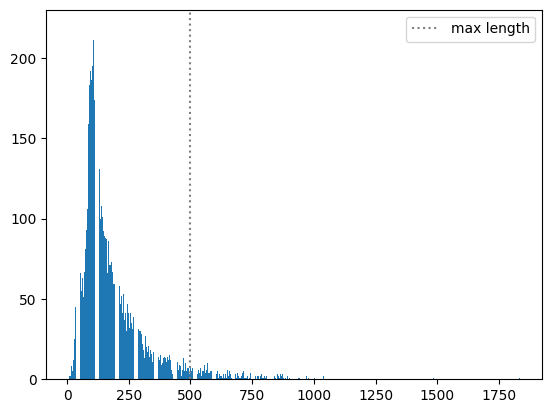

In [27]:
# 选择 max_length
length_collect = {}
for text, label in train_ds:
    length = len(text)
    length_collect[length] = length_collect.get(length, 0) + 1
    
MAX_LENGTH = 500
plt.bar(length_collect.keys(), length_collect.values())
plt.axvline(MAX_LENGTH, label="max length", c="gray", ls=":")
plt.legend()
plt.show()

## Tokenizer

In [28]:
class Tokenizer:
    def __init__(self, word2idx, idx2word, max_length=500, pad_idx=0, bos_idx=1, eos_idx=3, unk_idx=2):
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.max_length = max_length
        self.pad_idx = pad_idx
        self.bos_idx = bos_idx
        self.eos_idx = eos_idx
        self.unk_idx = unk_idx
    
    def encode(self, text_list, padding_first=False):
        """如果padding_first == True，则padding加载前面，否则加载后面"""
        max_length = min(self.max_length, 2 + max([len(text) for text in text_list]))
        indices_list = []
        for text in text_list:
            indices = [self.bos_idx] + [self.word2idx.get(word, self.unk_idx) for word in text[:max_length-2]] + [self.eos_idx] #变为id，未登录词用unk_idx代替，句子前后加bos和eos
            if padding_first: # padding加载前面
                indices = [self.pad_idx] * (max_length - len(indices)) + indices
            else:# padding加载后面
                indices = indices + [self.pad_idx] * (max_length - len(indices))
            indices_list.append(indices)
        return torch.tensor(indices_list)
    
    
    def decode(self, indices_list, remove_bos=True, remove_eos=True, remove_pad=True, split=False):
        text_list = []
        for indices in indices_list:
            text = []
            for index in indices:
                word = self.idx2word.get(index, "[UNK]")
                if remove_bos and word == "[BOS]":
                    continue
                if remove_eos and word == "[EOS]":
                    break
                if remove_pad and word == "[PAD]":
                    break
                text.append(word)
            text_list.append(" ".join(text) if not split else text)
        return text_list
    

tokenizer = Tokenizer(word2idx=word2idx, idx2word=idx2word)
raw_text = ["hello world".split(), "i really liked sum@@ mer@@ sla@@ m due look a@@ ren@@ a , cur@@ ".split(), "this is a test".split()]
indices = tokenizer.encode(raw_text, padding_first=False)

print("raw text-------------------")
for raw in raw_text:
    print(raw)
print("indices---------------")
for index in indices:
    print(index)


raw text-------------------
['hello', 'world']
['i', 'really', 'liked', 'sum@@', 'mer@@', 'sla@@', 'm', 'due', 'look', 'a@@', 'ren@@', 'a', ',', 'cur@@']
['this', 'is', 'a', 'test']
indices---------------
tensor([   1, 6513,  125,    3,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])
tensor([   1,    6,   27,  514, 2230,  775, 1527,  146,  893,   65,   98,  666,
          26,    5, 1571,    3])
tensor([   1,   18,  395,   26, 1892,    3,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])


In [29]:
idx2word[2230]

'sum@@'

In [30]:
decode_text = tokenizer.decode(indices.tolist(), remove_bos=False, remove_eos=False, remove_pad=False)
print("decode text")
for decode in decode_text:
    print(decode)

decode text
[BOS] hello world [EOS] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[BOS] i really liked sum@@ mer@@ sla@@ m due look a@@ ren@@ a , cur@@ [EOS]
[BOS] this is a test [EOS] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [31]:
import re

# 输入字符串
text = "i really liked sum@@ mer@@ sla@@ m due look a@@ ren@@ a , cur@@ "

# 使用正则表达式替换 "@@ " 为空字符串
cleaned_text = re.sub(r'@@\s*', '', text)

print(cleaned_text)

i really liked summerslam due look arena , cur


In [32]:
def collate_fct(batch):
    """
    把字符串列表转化为tensor
    :param batch:
    :return:
    """
    text_list = [item[0] for item in batch] #batch中每个item的第一个元素是text,是输入，类型为list
    label_list = [item[1] for item in batch] #batch中每个item的第二个元素是label,是输出，类型为int
    # 这里使用 padding first
    text_list = tokenizer.encode(text_list, padding_first=True).to(dtype=torch.int)
    return text_list, torch.tensor(label_list).reshape(-1, 1).to(dtype=torch.float)

batch_size = 128
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fct)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fct)

# 定义模型

In [33]:
class LSTM(nn.Module):
    def __init__(self, embedding_dim=16, hidden_dim=64, vocab_size=vocab_size, num_layers=1, bidirectional=False):
        super(LSTM, self).__init__()
        self.embeding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        self.layer = nn.Linear(hidden_dim * (2 if bidirectional else 1), hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        # [bs, seq length]
        x = self.embeding(x)
        # [bs, seq length, embedding_dim] -> shape [bs, seq length, hidden_dim ]
        seq_output, (hidden, cell) = self.lstm(x)

        x = seq_output[:, -1, :]
        # 取最后一个时间步的输出 (这也是为什么要设置padding_first=True的原因)
        x = self.layer(x)
        x = self.fc(x)
        return x
    
sample_inputs = torch.randint(0, vocab_size, (2, 128))
    
print("{:=^80}".format(" 一层单向 LSTM "))       
for key, value in LSTM().named_parameters():
    print(f"{key:^40}paramerters num: {np.prod(value.shape)}")

    
print("{:=^80}".format(" 一层双向 LSTM "))       
for key, value in LSTM(bidirectional=True).named_parameters():
    print(f"{key:^40}paramerters num: {np.prod(value.shape)}")

    
print("{:=^80}".format(" 两层单向 LSTM "))       
for key, value in LSTM(num_layers=2).named_parameters():
    print(f"{key:^40}paramerters num: {np.prod(value.shape)}")


================================== 一层单向 LSTM ===================================
            embeding.weight             paramerters num: 128560
           lstm.weight_ih_l0            paramerters num: 4096
           lstm.weight_hh_l0            paramerters num: 16384
            lstm.bias_ih_l0             paramerters num: 256
            lstm.bias_hh_l0             paramerters num: 256
              layer.weight              paramerters num: 4096
               layer.bias               paramerters num: 64
               fc.weight                paramerters num: 64
                fc.bias                 paramerters num: 1
================================== 一层双向 LSTM ===================================
            embeding.weight             paramerters num: 128560
           lstm.weight_ih_l0            paramerters num: 4096
           lstm.weight_hh_l0            paramerters num: 16384
            lstm.bias_ih_l0             paramerters num: 256
            lstm.bias_hh_l0         

# 训练

In [34]:
from sklearn.metrics import accuracy_score

@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)         # 验证集损失
        loss_list.append(loss.item())
        # 二分类
        preds = logits > 0
        pred_list.extend(preds.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())
        
    acc = accuracy_score(label_list, pred_list)
    return np.mean(loss_list), acc


### TensorBoard 可视化


训练过程中可以使用如下命令启动tensorboard服务。

```shell
tensorboard \
    --logdir=runs \     # log 存放路径
    --host 0.0.0.0 \    # ip
    --port 8848         # 端口
```

In [35]:
from torch.utils.tensorboard import SummaryWriter


class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))
        
    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss", 
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
            )
        
    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )
        
    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,
            
        )
    
    def __call__(self, step, **kwargs):
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)


2025-02-07 10:28:16.211618: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738895296.371171     307 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738895296.416487     307 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-07 10:28:16.812952: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Save Best


In [37]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch. 
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1
        
        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)
        
    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return
        
        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))



### Early Stop

In [38]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute 
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0
        
    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else: 
            self.counter += 1
            
    @property
    def early_stop(self):
        return self.counter >= self.patience


In [39]:
# 训练
def training(
    model, 
    train_loader, 
    val_loader, 
    epoch, 
    loss_fct, 
    optimizer, 
    tensorboard_callback=None,
    save_ckpt_callback=None,
    early_stop_callback=None,
    eval_step=500,
    ):
    record_dict = {
        "train": [],
        "val": []
    }
    
    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                preds = logits > 0
            
                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())    
                loss = loss.cpu().item()
                # record
                
                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                })
                
                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()
                    
                    # 1. 使用 tensorboard 可视化
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step, 
                            loss=loss, val_loss=val_loss,
                            acc=acc, val_acc=val_acc,
                            lr=optimizer.param_groups[0]["lr"],
                            )
                
                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict
                    
                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
        
    return record_dict
        

epoch = 20

model = LSTM()

# 1. 定义损失函数 采用交叉熵损失 (但是二分类)
loss_fct = F.binary_cross_entropy_with_logits
# 2. 定义优化器 采用 adam
# Optimizers specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 1. tensorboard 可视化
if not os.path.exists("runs"):
    os.mkdir("runs")
tensorboard_callback = TensorBoardCallback("runs/imdb-lstm-subword")
# tensorboard_callback.draw_model(model, [1, MAX_LENGTH])
# 2. save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback("checkpoints/imdb-lstm-subword", save_step=len(train_dl), save_best_only=True)
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=10)

model = model.to(device)
record = training(
    model, 
    train_dl, 
    test_dl, 
    epoch, 
    loss_fct, 
    optimizer, 
    tensorboard_callback=tensorboard_callback,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=len(train_dl)
    )

100%|██████████| 3920/3920 [02:46<00:00, 23.59it/s, epoch=19]


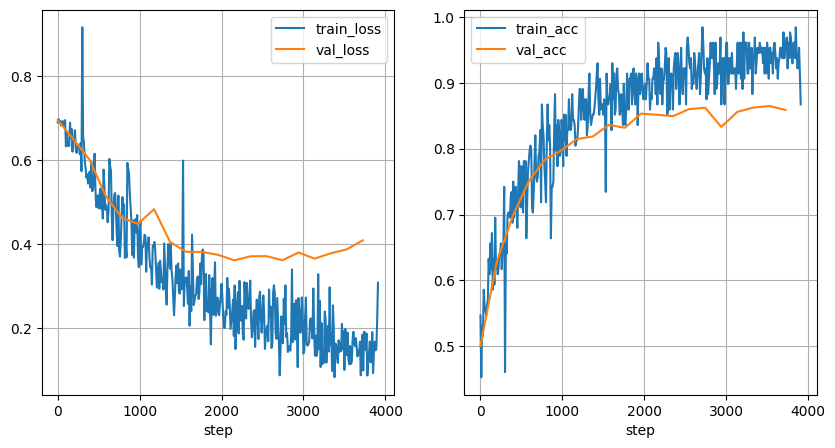

In [40]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):    
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        # axs[idx].set_xticks(range(0, train_df.index[-1], 5000))
        # axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", range(0, train_df.index[-1], 5000)))
        axs[idx].set_xlabel("step")
    
    plt.show()

plot_learning_curves(record, sample_step=10)  #横坐标是 steps

# 评估

In [41]:
# dataload for evaluating

# load checkpoints
model.load_state_dict(torch.load("checkpoints/imdb-lstm-subword/best.ckpt", map_location="cpu"))

model.eval()
loss, acc = evaluating(model, test_dl, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

/tmp/ipykernel_307/1251314024.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoints/imdb-lstm-subword/best.ckpt", map_location="c

loss:     0.3873
accuracy: 0.8648
